## Detect Timeseries Anomalies 

Discover users who are accessing our curriculum pages way beyond the end of their codeup time. What would the dataframe look like? Use time series method for detecting anomalies, like exponential moving average with %b.

### Imports

In [1]:
import numpy as np
import pandas as pd
import math
from sklearn import metrics

from scipy.stats import entropy

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates #to format dates on our plots
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split


# This is to make sure matplotlib doesn't throw the following error:
# The next line fixes "TypeError: float() argument must be a string or a number, not 'Timestamp' matplotlib"
pd.plotting.register_matplotlib_converters()

### Aquire Data

In [2]:
df= pd.read_csv('anonymized-curriculum-access.txt', sep=" ", header=None)

df.head()

,0,1,2,3,4,5
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 719459 entries, 0 to 719458
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       719459 non-null  object 
 1   1       719459 non-null  object 
 2   2       719458 non-null  object 
 3   3       719459 non-null  int64  
 4   4       674619 non-null  float64
 5   5       719459 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 32.9+ MB


### Prep Data

In [4]:
# Set column names
df.columns = ['date', 'time', 'page_viewed', 'user_id', 'cohort_id', 'ip']

In [5]:
df

,date,time,page_viewed,user_id,cohort_id,ip
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61
...,...,...,...,...,...,...
719454,2020-11-02,16:48:13,javascript-i/coffee-project,763,62.0,107.192.148.199
719455,2020-11-02,16:48:17,javascript-i/mapbox-api,771,62.0,172.125.226.175
719456,2020-11-02,16:48:18,javascript-i/coffee-project,771,62.0,172.125.226.175
719457,2020-11-02,16:48:28,javascript-i/bom-and-dom/bom,771,62.0,172.125.226.175


In [6]:
# Create timestamp column 
df["timestamp"] = df["date"] + " " + df["time"]

# Convert timestamp column to datetime type
df.timestamp = pd.to_datetime(df.timestamp)

# Set timestamp column as index
df = df.set_index('timestamp')

# Drop date and time columns
df.drop(columns=['date', 'time'], inplace = True)

# Show data
df.head()

,page_viewed,user_id,cohort_id,ip
timestamp,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [7]:
df.describe()

,user_id,cohort_id
count,719459.000000,674619.000000
mean,392.945478,37.173660
std,211.655544,14.971385
min,1.000000,1.000000
25%,230.000000,26.000000
50%,417.000000,32.000000
75%,568.000000,53.000000
max,787.000000,62.000000


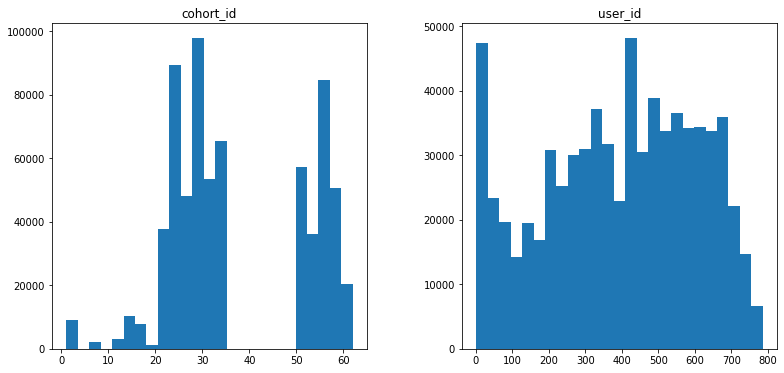

In [8]:
df.hist(figsize=(13, 6),
        grid=False,
        bins=25);

In [9]:
df.nunique()

page_viewed    2153
user_id         787
cohort_id        40
ip             4339
dtype: int64

### Split into Train/Test

In [10]:
train, test = train_test_split(df, test_size=.2, random_state=123)
train, validate = train_test_split(df, test_size=.3, random_state=123)

print(f'Train size: {len(train) / len(df):.2%}')
print(f'Validate size: {len(validate) / len(df):.2%}')
print(f'Test size: {len(test) / len(df):.2%}')

Train size: 70.00%
Validate size: 30.00%
Test size: 20.00%


In [11]:
df_unique_daily_events = train.resample('D').nunique()

### Exponential Moving Average with %b for Pages Viewed

In [12]:
ema_short = train.ewm(span=12, adjust=False).mean()
ema_short.tail()

,user_id,cohort_id
timestamp,,
2019-02-08 14:08:32,331.002480,35.851716
2019-02-06 12:12:56,329.925175,34.797606
2018-03-02 14:46:45,281.936687,32.828743
2018-03-19 12:17:44,257.177196,31.316629
2019-06-05 15:34:23,280.380705,31.421763


In [13]:
span = 24
ema_long = train.ewm(span=span, adjust=False).mean()
ema_long.tail()

,user_id,cohort_id
timestamp,,
2019-02-08 14:08:32,371.180963,37.696189
2019-02-06 12:12:56,367.406486,37.000494
2018-03-02 14:46:45,339.453967,35.800454
2018-03-19 12:17:44,321.977650,34.776418
2019-06-05 15:34:23,328.859438,34.554305


Text(0, 0.5, 'Times Page Viewed')

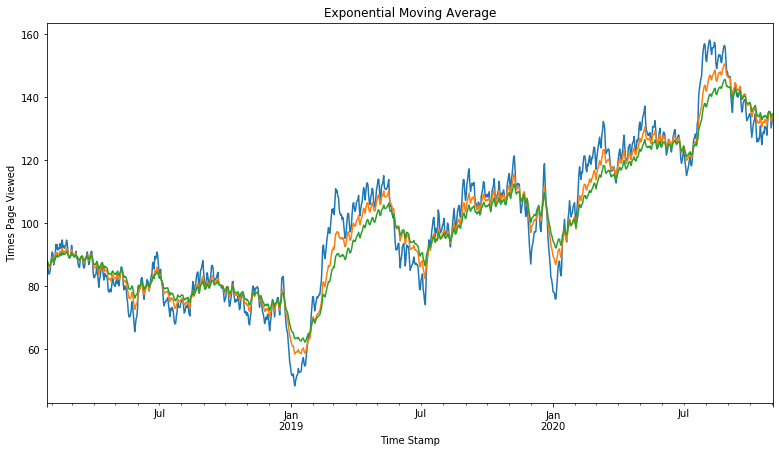

In [14]:
df_unique_daily_events.page_viewed.ewm(span=30, adjust=False).mean().plot(figsize=(13, 7));
df_unique_daily_events.page_viewed.ewm(span=60, adjust=False).mean().plot(figsize=(13, 7));
df_unique_daily_events.page_viewed.ewm(span=90, adjust=False).mean().plot(figsize=(13, 7))
plt.title('Exponential Moving Average')
plt.xlabel('Time Stamp')
plt.ylabel('Times Page Viewed')

Text(0, 0.5, 'Times Page Viewed')

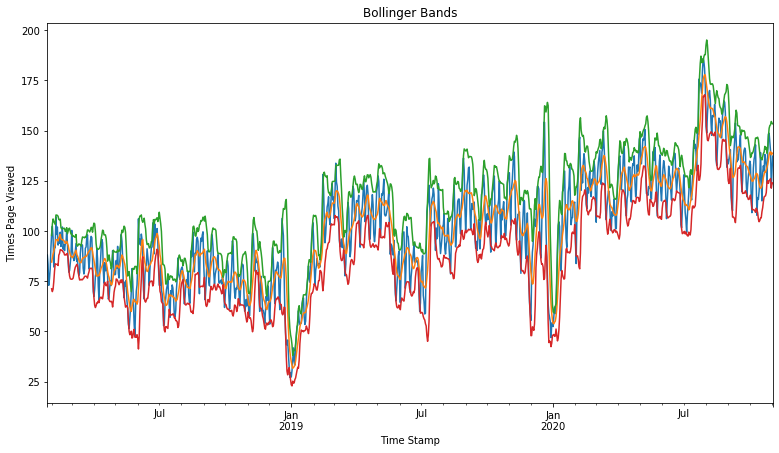

In [15]:
ema_long = df_unique_daily_events.page_viewed.ewm(span=7, adjust=False).mean()
midband = ema_long.rolling(7).mean()
ub = midband + ema_long.rolling(7).std()*1.5
lb = midband - ema_long.rolling(7).std()*1.5

ema_long.plot(figsize=(13, 7))
midband.plot()
ub.plot()
lb.plot()
plt.title('Bollinger Bands')
plt.xlabel('Time Stamp')
plt.ylabel('Times Page Viewed')